In [ ]:
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.lens_pop import LensPop
import numpy as np
import slsim.Sources as sources
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
import matplotlib.pyplot as plt
from slsim.image_simulation import point_source_coordinate_properties
from slsim.Plots.plot_functions import create_image_montage_from_image_list
import astropy.coordinates as coord
import astropy.units as u
from slsim.LsstSciencePipeline import opsim_pipeline
from slsim.LsstSciencePipeline.util_lsst import opsim_variable_lens_injection

## Supernovae plus extended source simulation
In this notebook, we simulate population of lensed supernovae and simulate image of a 

random lensed supernovae. It follows following steps:

1. Simulate lensed supernovae population
2. Choose a lens at random
3. Set observation time and other image configuration
4. Simulate image of a selected lens
5. Visualize it

Before running this notebook, please download the "scotch_SNIa_host_galaxies.fits"

file from the following link: https://github.com/LSST-strong-lensing/data_public.git. 

This file contains type Ia supernovae host galaxies.

## Simulate lensed supernovae population

In [2]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
deflector_sky_area = Quantity(value=1, unit="deg2")
source_sky_area = Quantity(value=5, unit="deg2")
sky_area = Quantity(value=1, unit="deg2")
sky_area_full = Quantity(value=2000, unit="deg2")

kwargs_deflector_cut = {"band": "g", "band_max": 24, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"z_min": 0.1, "z_max": 5.0}

time_range = np.linspace(-50, 100, 500)

In [3]:
# Generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None, sky_area=sky_area, filters=None, cosmo=cosmo
)

In [4]:
# Initiate deflector population class.
lens_galaxies = deflectors.AllLensGalaxies(
    red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light=None,
    cosmo=cosmo,
    sky_area=sky_area,
)

/Users/narayankhadka/slsim/slsim/Deflectors/all_lens_galaxies.py:54: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  red_galaxy_list = catalog_with_angular_size_in_arcsec(
/Users/narayankhadka/slsim/slsim/Deflectors/all_lens_galaxies.py:57: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  blue_galaxy_list = catalog_with_angular_size_in_arcsec(


In [5]:
supernovae_catalog = sources.SupernovaeCatalog.SupernovaeCatalog(
    sn_type="Ia",
    band_list=["i"],
    lightcurve_time=time_range,
    absolute_mag_band="bessellb",
    absolute_mag=None,
    mag_zpsys="ab",
    cosmo=cosmo,
    skypy_config=None,
    sky_area=source_sky_area,
)
supernovae_data = supernovae_catalog.supernovae_catalog(
    host_galaxy=False, lightcurve=False
)

/Users/narayankhadka/slsim/slsim/Sources/Supernovae/supernovae_pop.py:95: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  numerator = integrate.quad(
/Users/narayankhadka/slsim/slsim/Sources/Supernovae/supernovae_pop.py:95: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  numerator = integrate.quad(
/Users/narayankhadka/slsim/slsim/Sources/Supernovae/supernovae_pop.py:95: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  numerator = int

In [ ]:
# Initiate source population class.
kwargs_sn = {
            "variability_model": "light_curve",
            "kwargs_variability": ["supernovae_lightcurve", "i"],
            "sn_type": "Ia",
            "sn_absolute_mag_band": "bessellb",
            "sn_absolute_zpsys": "ab",
            "lightcurve_time": time_range,
            "sn_modeldir": None,
        }
supernovae_sourece = sources.PointSources(
    point_source_list=supernovae_data,
    cosmo=cosmo,
    sky_area=source_sky_area,
    kwargs_cut=kwargs_source_cut,
    pointsource_type="supernova",
    **kwargs_sn
)

In [7]:
# Initiate LensPop class
supernova_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=supernovae_sourece,
    sky_area=sky_area_full,
    cosmo=cosmo,
)

## Draw lens population

In [8]:
# specifying cuts of the population
kwargs_lens_cuts = {}
# drawing population
supernovae_lens_population = supernova_lens_pop.draw_population(
    kwargs_lens_cuts=kwargs_lens_cuts, speed_factor=100, multi_source=False
)

## Choose a lens to simulate an image

In [20]:
kwargs_lens_cut = {"min_image_separation": 1, "max_image_separation": 10}
rgb_band_list = ["i", "r", "g"]
lens_class = supernovae_lens_population[51]

In [57]:
pix_coord = point_source_coordinate_properties(
    lens_class,
    band="i",
    mag_zero_point=27,
    delta_pix=0.2,
    num_pix=63,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
)["image_pix"]

## See the light curve of a selected supernovae

In [23]:
light_curve = lens_class.source[0].variability_class.kwargs_model

(-22.0, 100.0)

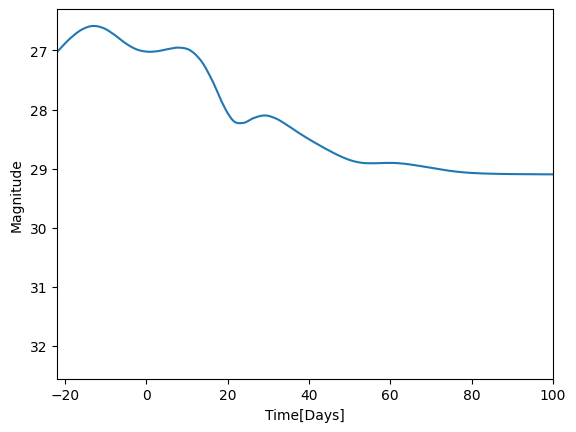

In [24]:
plt.plot(light_curve["MJD"], light_curve["ps_mag_i"])
# plt.ylim(12, 18)
plt.gca().invert_yaxis()
plt.ylabel("Magnitude")
plt.xlabel("Time" "[Days]")
plt.xlim(-22, 100)

## Get observation properties from OpSim

In [29]:
# np.random.seed(1)
N = 10

ra_points = coord.Angle(np.random.uniform(low=0, high=360, size=N) * u.degree)
ra_points = ra_points.wrap_at(180 * u.degree)
dec_points = np.arcsin(2 * np.random.uniform(size=N) - 1) / np.pi * 180
dec_points = coord.Angle(dec_points * u.degree)

In [ ]:
# opsim_path is a path for opsim summary data. One need to download baseline_v3.4_10yrs.db
# to run this pipeline. Please download this data from and replace opsim_path with your path:
# https://epyc.astro.washington.edu/~lynnej/opsim_downloads/fbs_3.4/initial/initial_v3.4_10yrs.db
exposure_data = opsim_pipeline.opsim_time_series_images_data(
    ra_points,
    dec_points,
    "baseline_v3.0_10yrs",
    print_warning=True,
    num_pix=63,
    opsim_path="/Users/narayankhadka/downloads/baseline_v3.4_10yrs.db",
)

Reading from database sqlite:////Users/narayankhadka/downloads/baseline_v3.4_10yrs.db
Read N = 2146797 observations in 31.70 seconds.
No host file.
Coordinate (-29.610298340248505 deg, 15.139325286485471 deg) is not in the LSST footprint. This entry is skipped.
Coordinate (-148.54533161882097 deg, 77.27652525868886 deg) is not in the LSST footprint. This entry is skipped.
Coordinate (-154.53996614062493 deg, 61.26860785418272 deg) is not in the LSST footprint. This entry is skipped.
Coordinate (-106.79085603571352 deg, 27.918324749459078 deg) is not in the LSST footprint. This entry is skipped.
Coordinate (-82.67094082370238 deg, 32.545704814609024 deg) is not in the LSST footprint. This entry is skipped.


## Inject selected lens to a prepared time series data 

In [60]:
# There are multiple time series datasets, so I chose the first one.
index = 0
bands = ["i"]
num_pix = 63
transform_pix2angle = np.array([[0.2, 0], [0, 0.2]])

images = opsim_variable_lens_injection(
    lens_class, bands, num_pix, transform_pix2angle, exposure_data[index]
)

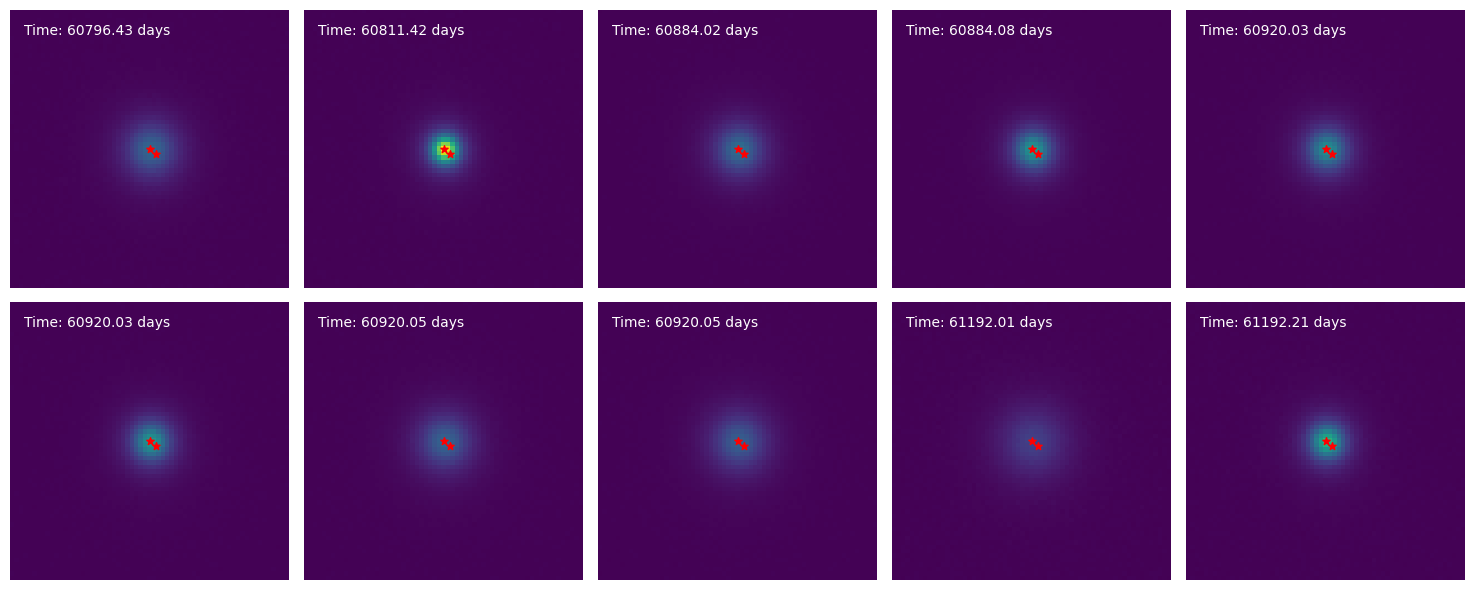

In [64]:
## Plot first 10 images. One can plot any number of images
plot_montage = create_image_montage_from_image_list(
    num_rows=2,
    num_cols=5,
    images=images["injected_lens"][:10],
    image_center=[pix_coord[0][0], pix_coord[1][0]],
    time=images["obs_time"][:10],
)